In [61]:
from analyzer import Analyzer
from multiprocessing import Pool
from tools import *
import matplotlib.pyplot as plt
from scipy.io import savemat
import seaborn as sns
import pandas as pd
import numpy as np
import os

In [62]:

dataset = "dogs3"

true_adj_matrix = retrieve_true_adj_matrix(dataset)
size = size_of_dataset(dataset)
num_vs_time_per_question = {}
demo_completion_time = {}
total_completion_time = {}
num_vs_error = []

if dataset == "birds5":
    files = [
        (7, "same-demo-random-query-with-practice-7-birds5-06-24-22-n=50", 0),
        (8, "same-demo-random-query-with-practice-8-birds5-06-24-22-n=50", 0),
        (7, "same-demo-random-query-with-practice-7-new-ui-birds5-06-24-22-n=50", 1),
        (8, "same-demo-random-query-with-practice-8-new-ui-birds5-06-24-22-n=50", 1),
    ]
else:
    files = [
        (7, "same-demo-random-query-with-practice-7-06-24-22-n=50", 0),
        (8, "same-demo-random-query-with-practice-8-06-24-22-n=50", 0),
        (7, "same-demo-random-query-with-practice-7-new-ui-06-24-22-n=50", 1),
        (8, "same-demo-random-query-with-practice-8-new-ui-06-24-22-n=50", 1),
    ]

for num, file, ui_status in files:
    np.random.seed(0)
    analyer = Analyzer("./data/{}.json".format(file),
                       size, true_adj_matrix(), radio=False, dataset=dataset)

    time_per_question = analyer.times
    number_correct_edges = list(map(lambda x: x.worker_edge_correct, analyer.workers_answers))
    total_number_edges = list(map(lambda x: x.worker_edge_correct + x.worker_edge_incorrect, analyer.workers_answers))
    num_0 = list(map(lambda x: x.num_0, analyer.workers_answers))
    num_0_correct = list(map(lambda x: x.num_0 - x.num_0_to_1, analyer.workers_answers))
    num_1 = list(map(lambda x: x.num_1, analyer.workers_answers))
    num_1_correct = list(map(lambda x: x.num_1 - x.num_1_to_0, analyer.workers_answers))

    for i in range(len(number_correct_edges)):
        _data = [num]
        _data.append(number_correct_edges[i])
        _data.append(total_number_edges[i])
        _data.append(num_1[i])
        _data.append(num_1_correct[i])
        _data.append(num_0[i])
        _data.append(num_0_correct[i])
        _data.append(ui_status)
        num_vs_error.append(_data)

    worker_edge_mat = np.array([
        number_correct_edges,
        total_number_edges,
        num_1,
        num_1_correct,
        num_0,
        num_0_correct,
        [ui_status for _ in range(len(num_0))]
    ]).T

    num_vs_time_per_question[(num, ui_status)] = list(zip(time_per_question, [ui_status for _ in range(len(time_per_question))]))
    demo_completion_time[(num, ui_status)] = list(map(lambda x: x['demo'].demo_completion_time, analyer.raw_data.values()))
    total_completion_time[(num, ui_status)] = list(map(lambda x: x['demo'].demo_completion_time + sum(x['practice'].times()) + sum(x['answer'].times()), analyer.raw_data.values()))
    savemat("./mats/{}_worker_edge_mat_{}.mat".format(file, dataset), {"worker_edge_mat": worker_edge_mat})

In [63]:
num_vs_error_df = pd.DataFrame(num_vs_error, columns=["num_images_per_question", "num_correct_edges", "num_edges", "num_1", "num_1_correct", "num_0", "num_0_correct", "ui_status"])
num_vs_error_df["ui_status"] = num_vs_error_df["ui_status"].replace(
    0, "old_ui")
num_vs_error_df["ui_status"] = num_vs_error_df["ui_status"].replace(
    1, "new_ui")
num_vs_error_df.to_csv(f"./csv/edge_error_per_worker_{dataset}_ui_compare.csv", index=False)

In [64]:
x = sum(map(lambda _x: [_x[0][0] for _ in range(len(_x[1]))], num_vs_time_per_question.items()), [])
y_and_z = sum(num_vs_time_per_question.values(), [])
y = list(map(lambda _x: _x[0], y_and_z))
z = list(map(lambda _x: _x[1], y_and_z))
time_data = pd.DataFrame(
    {"num_images_per_question": x, "time_per_question": y, "ui_status": z})
time_data.to_csv(
    f"./csv/time_per_question_{dataset}_ui_compare.csv", index=False)
time_data["ui_status"] = time_data["ui_status"].replace(0, "old_ui")
time_data["ui_status"] = time_data["ui_status"].replace(1, "new_ui")

In [65]:
x = []
y = []
z = []

for (num, ui_status), times in demo_completion_time.items():
    x += [num for _ in range(len(times))]
    y += times
    z += [ui_status for _ in range(len(times))]

demo_completion_time_data = pd.DataFrame({"num_images_per_question": x, "demo_completion_time": y, "ui_status": z})    
demo_completion_time_data.to_csv(
    f"./csv/demo_completion_time_data_{dataset}_ui_compare.csv", index=False)
demo_completion_time_data["ui_status"] = demo_completion_time_data["ui_status"].replace(
    0, "old_ui")
demo_completion_time_data["ui_status"] = demo_completion_time_data["ui_status"].replace(
    1, "new_ui")


In [66]:
x = []
y = []
z = []

for (num, ui_status), times in total_completion_time.items():
    x += [num for _ in range(len(times))]
    y += times
    z += [ui_status for _ in range(len(times))]

total_completion_time_data = pd.DataFrame(
    {"num_images_per_question": x, "total_completion_time": y, "ui_status": z})
total_completion_time_data.to_csv(
    f"./csv/total_completion_time_{dataset}_ui_compare.csv", index=False)
total_completion_time_data["ui_status"] = total_completion_time_data["ui_status"].replace(
    0, "old_ui")
total_completion_time_data["ui_status"] = total_completion_time_data["ui_status"].replace(
    1, "new_ui")


In [67]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (10, 6)

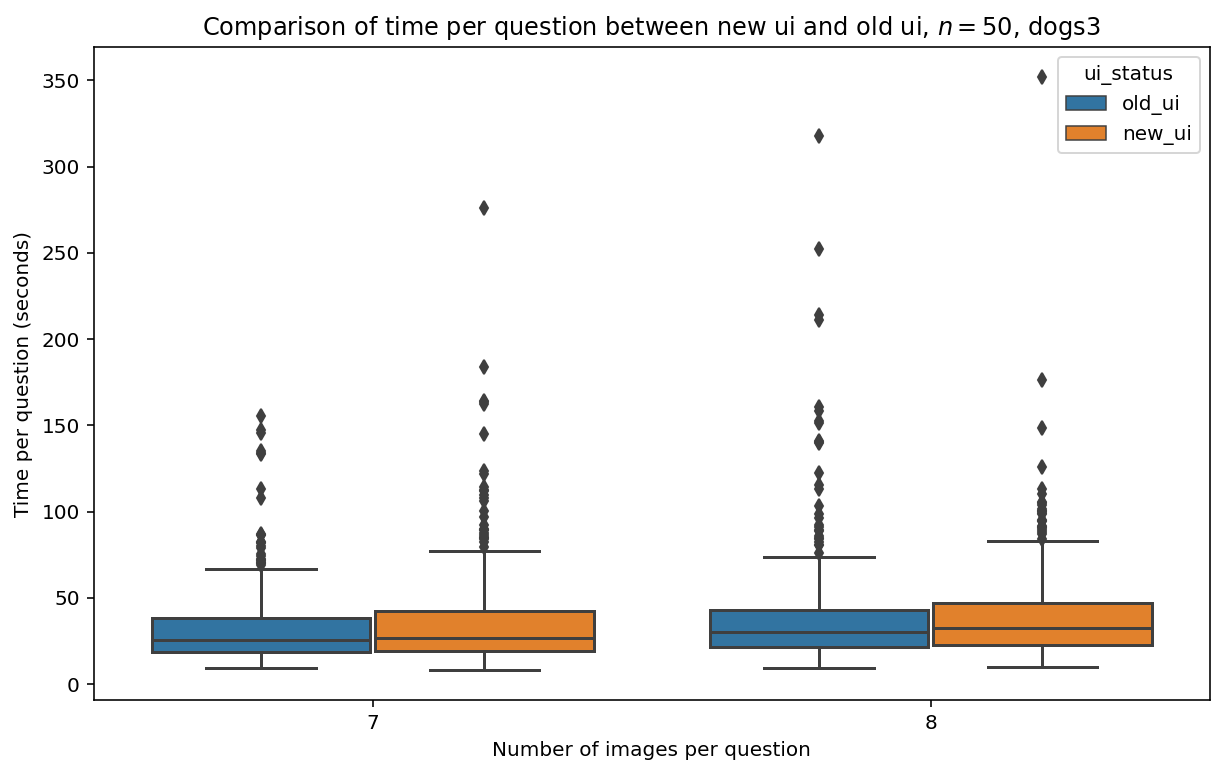

In [68]:
fig = sns.boxplot(x="num_images_per_question", y="time_per_question", hue="ui_status", data=time_data)
fig.set_title(f"Comparison of time per question between new ui and old ui, $n=50$, {dataset}")
fig.set_xlabel("Number of images per question")
fig.set_ylabel("Time per question (seconds)")
plt.savefig(f"./plots/time_per_question_{dataset}_ui_compare.png", dpi=300,
            facecolor='white', transparent=False)
plt.show()

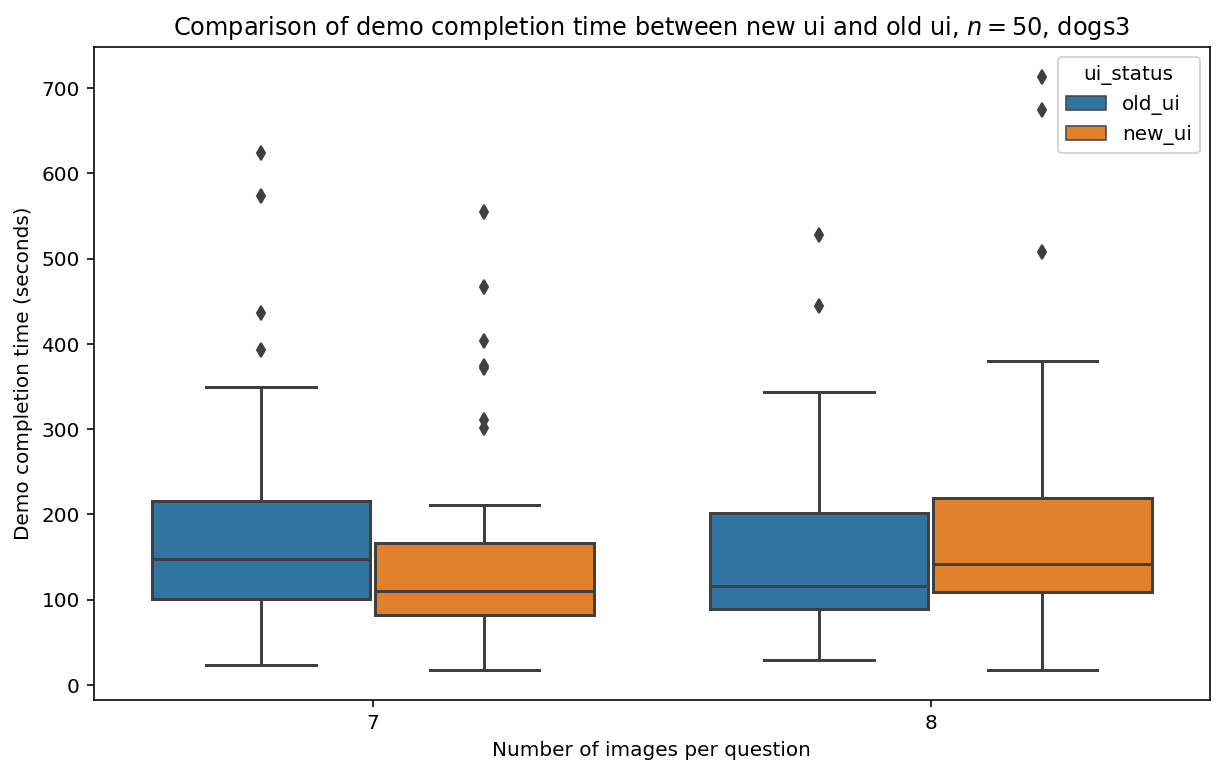

In [69]:
fig = sns.boxplot(x="num_images_per_question",
                  y="demo_completion_time", hue="ui_status", data=demo_completion_time_data)
fig.set_title(
    f"Comparison of demo completion time between new ui and old ui, $n=50$, {dataset}")
fig.set_xlabel("Number of images per question")
fig.set_ylabel("Demo completion time (seconds)")
plt.savefig(f"./plots/demo_completion_time_{dataset}_ui_compare.png", dpi=300,
            facecolor='white', transparent=False)
plt.show()

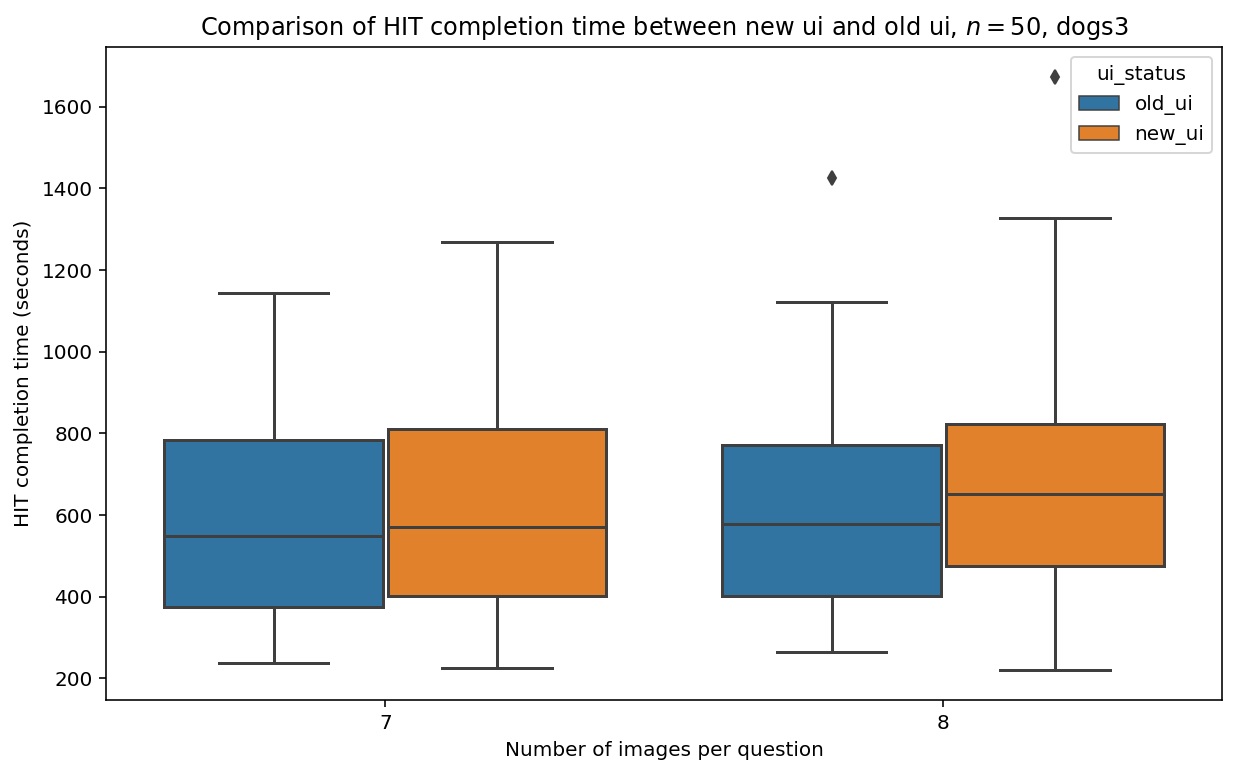

In [70]:
fig = sns.boxplot(
    x="num_images_per_question", y="total_completion_time", hue="ui_status",
    data=total_completion_time_data)
fig.set_title(
    f"Comparison of HIT completion time between new ui and old ui, $n=50$, {dataset}")
fig.set_xlabel("Number of images per question")
fig.set_ylabel("HIT completion time (seconds)")
plt.savefig(f"./plots/HIT_completion_time_{dataset}_ui_compare.png", dpi=300,
            facecolor='white', transparent=False)
plt.show()

In [71]:
num_vs_error_df["edge_error_rate"] = 1 - num_vs_error_df["num_correct_edges"] / num_vs_error_df["num_edges"]

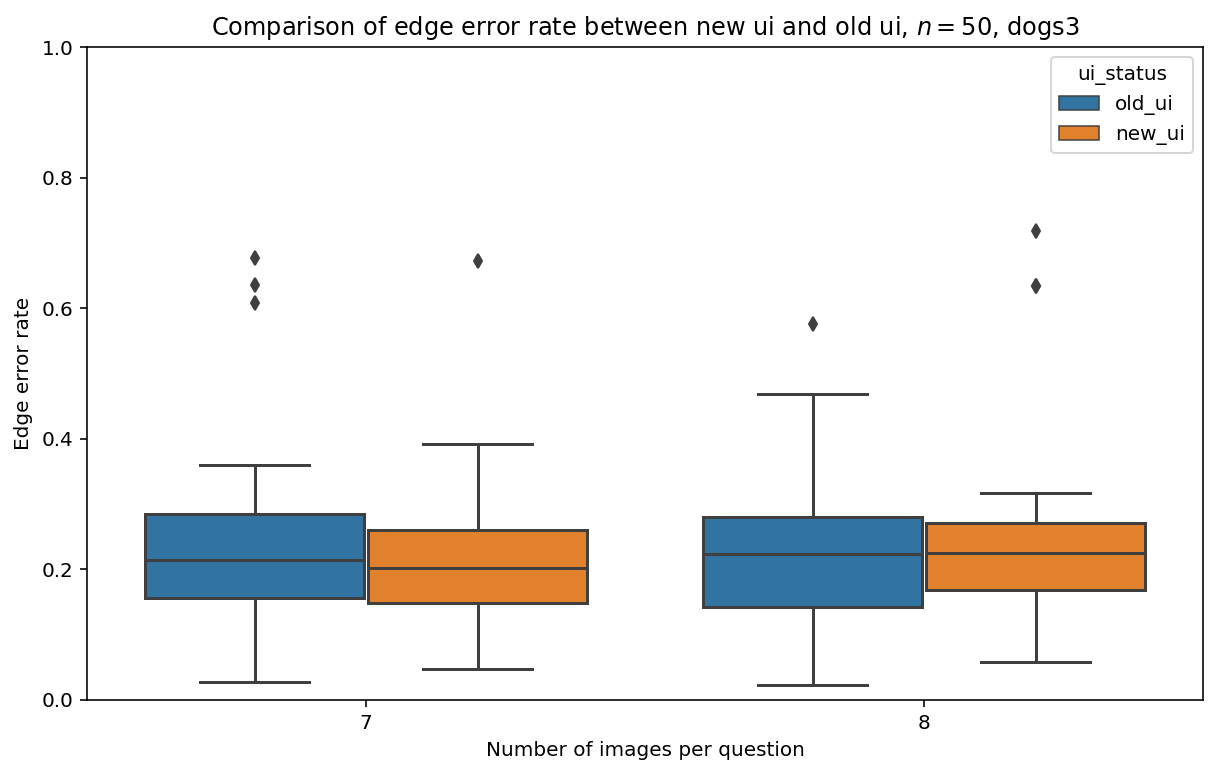

In [72]:
fig = sns.boxplot(
    x="num_images_per_question", y="edge_error_rate", hue="ui_status",
    data=num_vs_error_df)
fig.set_title(
    f"Comparison of edge error rate between new ui and old ui, $n=50$, {dataset}")
fig.set_ylim([0, 1])
fig.set_xlabel("Number of images per question")
fig.set_ylabel("Edge error rate")
plt.savefig(f"./plots/edge_error_rate_{dataset}_ui_compare.png", dpi=300,
            facecolor='white', transparent=False)
plt.show()

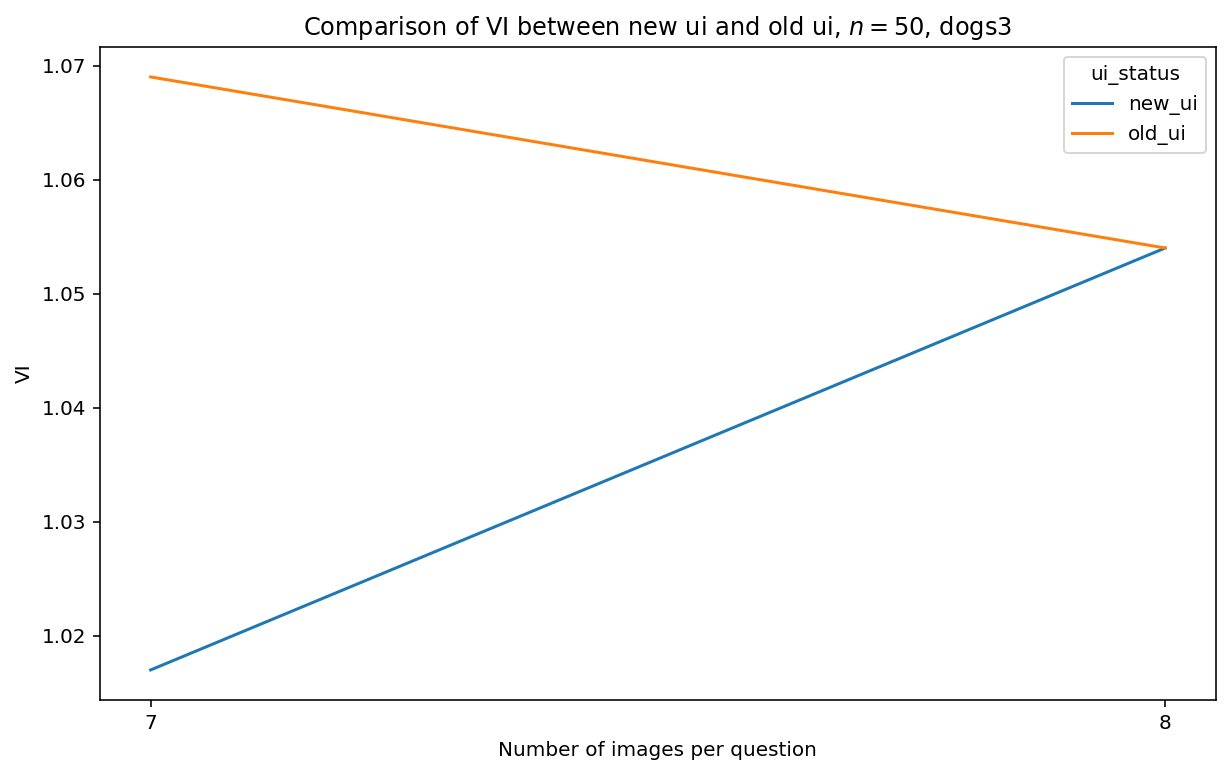

In [73]:
vi = pd.read_csv(f"./csv/vi_{dataset}_ui_compare.csv")
fig = sns.lineplot(
    x="num_images_per_question", y="vi", hue="ui_status",
    data=vi)
fig.set_xticks([7, 8])
fig.set_title(
    f"Comparison of VI between new ui and old ui, $n=50$, {dataset}")
fig.set_xlabel("Number of images per question")
fig.set_ylabel("VI")
plt.savefig(f"./plots/VI_{dataset}_ui_compare.png", dpi=300,
            facecolor='white', transparent=False)
plt.show()